# Multi-Task Learning for Food Ingredient Classification and Segmentation 
### Deep Learning for Visual Recognition

### 1. Dataset Exploration
#### 1.1 Load FoodSeg103

In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import torch, torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import list_models, get_model
from datasets import Dataset
import pandas as pd
import json

ds = load_dataset("EduardoPacheco/FoodSeg103")

with open("data/idtolabel.json") as f:
    id2label = json.load(f)

num_classes = len(id2label)
label_to_idx = {v:k for k,v in id2label.items()}
label_list = list(label_to_idx.keys())

print(f"Number of classes: {num_classes}")
label_list

Number of classes: 104


['background',
 'candy',
 'egg tart',
 'french fries',
 'chocolate',
 'biscuit',
 'popcorn',
 'pudding',
 'ice cream',
 'cheese butter',
 'cake',
 'wine',
 'milkshake',
 'coffee',
 'juice',
 'milk',
 'tea',
 'almond',
 'red beans',
 'cashew',
 'dried cranberries',
 'soy',
 'walnut',
 'peanut',
 'egg',
 'apple',
 'date',
 'apricot',
 'avocado',
 'banana',
 'strawberry',
 'cherry',
 'blueberry',
 'raspberry',
 'mango',
 'olives',
 'peach',
 'lemon',
 'pear',
 'fig',
 'pineapple',
 'grape',
 'kiwi',
 'melon',
 'orange',
 'watermelon',
 'steak',
 'pork',
 'chicken duck',
 'sausage',
 'fried meat',
 'lamb',
 'sauce',
 'crab',
 'fish',
 'shellfish',
 'shrimp',
 'soup',
 'bread',
 'corn',
 'hamburg',
 'pizza',
 ' hanamaki baozi',
 'wonton dumplings',
 'pasta',
 'noodles',
 'rice',
 'pie',
 'tofu',
 'eggplant',
 'potato',
 'garlic',
 'cauliflower',
 'tomato',
 'kelp',
 'seaweed',
 'spring onion',
 'rape',
 'ginger',
 'okra',
 'lettuce',
 'pumpkin',
 'cucumber',
 'white radish',
 'carrot',
 'as

#### 1.2 Examples

In [ ]:
# Check the shapes of the first 10 images in the training set
for i in range(10):
    img = ds["train"][i]["image"]
    print(f"Image {i} size: {img.size}")  # (width, height)

In [ ]:
# Print a few examples from the training split
for i in range(3):
    example = ds["train"][i]
    print(f"ID: {example['id']}")
    print(f"Classes on image: {example['classes_on_image']}")
    class_names = [label_list[class_id] for class_id in example['classes_on_image']]
    print(f"Names of the classes on image: {class_names}")
    print(f"Label shape: {np.array(example['label']).shape}")
    plt.imshow(example['image'])
    plt.title(f"Example {i}")
    plt.axis('off')
    plt.show()

#### 1.3 Class Distribution

In [ ]:
from collections import Counter

# Calculate class distribution in the training set

all_classes = []
for example in ds["train"]:
    all_classes.extend(example["classes_on_image"])

class_counts = Counter(all_classes)
class_names_ordered = [label_list[class_id] for class_id in range(len(label_list))]
counts_ordered = [class_counts.get(class_id, 0) for class_id in range(len(label_list))]

plt.figure(figsize=(18, 6))
sns.barplot(x=class_names_ordered, y=counts_ordered)
plt.xticks(rotation=90)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution in Training Set")
plt.tight_layout()
plt.show()

### 2. Preprocessing

#### 2.1 Resize all images to same size

In [2]:
# Define torchvision transforms for resizing and tensor conversion
transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

label_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.PILToTensor()
])

def resize_and_to_tensor(example):
    example['image'] = transform(example['image'])
    example['label'] = label_transform(example['label']).long().squeeze(0)
    return example

# Apply resizing and tensor conversion to all splits
ds = ds.map(resize_and_to_tensor)
ds.set_format(type="torch", columns=["image", "label"])

In [3]:
import numpy as np

def one_hot_encode(example, num_classes):
    ingredient_vector = np.zeros(num_classes, dtype=np.float32)
    for cls in example["classes_on_image"]:
        ingredient_vector[int(cls)] = 1.0
    example["ingredient_vector"] = ingredient_vector
    return example

ds = ds.map(lambda x: one_hot_encode(x, num_classes))

In [4]:
train, validation = ds["train"], ds["validation"]
train, validation

(Dataset({
     features: ['image', 'label', 'classes_on_image', 'id', 'ingredient_vector'],
     num_rows: 4983
 }),
 Dataset({
     features: ['image', 'label', 'classes_on_image', 'id', 'ingredient_vector'],
     num_rows: 2135
 }))

In [5]:
print(type(train[0]['image']))
train[0]['label'].shape

<class 'torch.Tensor'>


torch.Size([1, 256, 256])

In [6]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train, batch_size=8, shuffle=True, num_workers=4
)
val_loader = DataLoader(
    validation, batch_size=8, shuffle=False, num_workers=4
)


In [7]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


### 3. Classification Model

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.DEFAULT)
model

In [ ]:
import torch.optim as optim

for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer to match our number of ingredient classes
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()  # For multi-label classification
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

In [ ]:
from tqdm import tqdm
import torch

num_epochs = 20  

print("Starting training the classification model")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    loop = tqdm(train_loader, desc=f"Epoch [{epoch + 1}/{num_epochs}] - Training", leave=False)
    for batch in loop:
        images = batch["image"].to(device)
        labels = batch["ingredient_vector"].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train)
    print(f"Epoch [{epoch + 1}/{num_epochs}] Training Loss: {epoch_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch [{epoch + 1}/{num_epochs}] - Validation", leave=False):
            images = batch["image"].to(device)
            labels = batch["ingredient_vector"].to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(validation)
    print(f"Epoch [{epoch + 1}/{num_epochs}] Validation Loss: {val_loss:.4f}")

# Save final model
torch.save(model.state_dict(), "models/resnet50_final.pth")


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score

import torch.nn.functional as F

# Collect predictions and targets for the entire validation set
all_targets = []
all_preds = []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        images = batch["image"].to(device)
        targets = batch["ingredient_vector"].cpu().numpy()
        logits = model(images)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        all_targets.append(targets)
        all_preds.append(preds)

all_targets = np.concatenate(all_targets, axis=0)
all_preds = np.concatenate(all_preds, axis=0)

# Compute metrics (macro-averaged)
precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall:    {recall:.4f}")
print(f"Validation F1:        {f1:.4f}")

# mAP (mean average precision) - optional
try:
    mAP = average_precision_score(all_targets, all_preds, average='macro')
    print(f"Validation mAP:       {mAP:.4f}")
except Exception as e:
    print("mAP calculation failed:", e)


In [ ]:
# Display several predictions
num_display = 5
for i, batch in enumerate(val_loader):
    images = batch["image"]
    targets = batch["ingredient_vector"]
    logits = model(images.to(device))
    probs = torch.sigmoid(logits).cpu().detach().numpy()
    preds = (probs > 0.5).astype(int)
    for j in range(min(len(images), num_display)):
        img_np = images[j].permute(1, 2, 0).cpu().detach().numpy().clip(0, 1)
        plt.imshow(img_np)
        plt.axis('off')
        true_labels = [label_list[k] for k in np.where(targets[j].cpu().detach().numpy() == 1)[0]]
        pred_labels = [label_list[k] for k in np.where(preds[j] == 1)[0]]
        plt.title(f"True: {true_labels}\nPred: {pred_labels}")
        plt.show()
        num_display -= 1
        if num_display == 0:
            break
    if num_display == 0:
        break

### 4. Segmentation Model

In [ ]:
model = get_model("deeplabv3_resnet50", weights="DEFAULT")
model.classifier[-1] = nn.Conv2d(model.classifier[-1].in_channels, num_classes, kernel_size=1)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 20

In [ ]:
model = model.to(device)

train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Training", leave=False)
    for batch in loop:
        images = batch["image"].to(device)
        labels = batch["label"].to(device).squeeze(1)  # shape: (N, H, W), dtype: long
        optimizer.zero_grad()
        outputs = model(images)["out"]
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        loop.set_postfix(loss=loss.item())
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

torch.save(model.state_dict(), "models/deeplabv3_resnet50_final.pth")

In [ ]:
import torch

def pixel_accuracy(outputs, labels):
    preds = torch.argmax(outputs, dim=1)
    correct = (preds == labels).float()
    acc = correct.sum() / correct.numel()
    return acc.item()

def per_class_iou(outputs, labels, num_classes):
    preds = torch.argmax(outputs, dim=1)
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (labels == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    return ious

def mean_iou(outputs, labels, num_classes):
    ious = per_class_iou(outputs, labels, num_classes)
    valid_ious = [iou for iou in ious if not np.isnan(iou)]
    return np.mean(valid_ious)

def dice_score(outputs, labels, num_classes):
    preds = torch.argmax(outputs, dim=1)
    dice_scores = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (labels == cls)
        intersection = (pred_inds & target_inds).sum().item()
        pred_sum = pred_inds.sum().item()
        target_sum = target_inds.sum().item()
        if pred_sum + target_sum == 0:
            dice_scores.append(float('nan'))
        else:
            dice_scores.append(2 * intersection / (pred_sum + target_sum))
    return dice_scores

# Example usage on validation set
model.eval()
pixel_accs = []
ious_list = []
dice_list = []

with torch.no_grad():
    for batch in val_loader:
        images = batch["image"].to(device)
        labels = batch["label"].to(device).squeeze(1)
        outputs = model(images)["out"]
        pixel_accs.append(pixel_accuracy(outputs, labels))
        ious = per_class_iou(outputs, labels, num_classes)
        dice = dice_score(outputs, labels, num_classes)
        ious_list.append(ious)
        dice_list.append(dice)

mean_pixel_acc = np.mean(pixel_accs)
mean_ious = np.nanmean(np.array(ious_list), axis=0)
mean_iou_score = np.nanmean(mean_ious)
mean_dice = np.nanmean(np.array(dice_list), axis=0)
mean_dice_score = np.nanmean(mean_dice)

print(f"Pixel Accuracy: {mean_pixel_acc:.4f}")
print(f"Per-class IoU: {mean_ious}")
print(f"Mean IoU: {mean_iou_score:.4f}")
print(f"Mean Dice Score: {mean_dice_score:.4f}")

In [ ]:
import torch

# Display side-by-side: original image, ground truth mask, predicted mask (overlayed and plain)
import matplotlib.pyplot as plt

# Get a batch from validation loader
batch = next(iter(val_loader))
images = batch["image"].to(device)
labels = batch["label"].cpu().numpy()  # (N, H, W)

# Get model predictions
model.eval()
with torch.no_grad():
    outputs = model(images)["out"]
    preds = torch.argmax(outputs, dim=1).cpu().numpy()  # (N, H, W)

# Show for the first 3 images in the batch
num_show = 3
for i in range(num_show):
    img = images[i].cpu().permute(1, 2, 0).numpy()
    img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # unnormalize
    img = img.clip(0, 1)

    gt_mask = labels[i]
    pred_mask = preds[i]

    # Overlay predicted mask on image
    overlay = img.copy()
    color_mask = np.zeros_like(img)
    color_mask[..., 0] = pred_mask / pred_mask.max()  # Red channel
    overlay = 0.6 * img + 0.4 * color_mask

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    axs[0].imshow(img)
    axs[0].set_title("Image")
    if gt_mask.ndim == 3 and gt_mask.shape[0] == 1:
        gt_mask = gt_mask.squeeze(0)
    axs[1].imshow(gt_mask, cmap='tab20')
    axs[1].set_title("GT Mask")
    axs[2].imshow(pred_mask, cmap='tab20')
    axs[2].set_title("Pred Mask")
    axs[3].imshow(overlay)
    axs[3].set_title("Overlay")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

### 5. Multi-Task Joint Training: Classification + Segmentation


In [8]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.segmentation import deeplabv3_resnet50


class MultiTaskDeepLab(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Load DeepLabV3-ResNet50 with correct classifier shape
        deeplab = deeplabv3_resnet50(weights=None, num_classes=num_classes)

        # Shared backbone
        self.backbone = deeplab.backbone      # dict: {"out": features}

        # Shared ASPP segmentation head
        self.segmentation_head = deeplab.classifier

        # Classification head (global pooled backbone features)
        self.classifier = nn.Linear(2048, num_classes)

    def forward(self, x):
        # 1. Backbone
        features = self.backbone(x)["out"]     # [B, 2048, H/32, W/32]

        # 2. Classification head
        pooled = F.adaptive_avg_pool2d(features, (1, 1)).flatten(1)
        cls_logits = self.classifier(pooled)

        # 3. Segmentation head
        seg_logits = self.segmentation_head(features)
        seg_logits = F.interpolate(seg_logits, size=x.shape[2:], mode="bilinear", align_corners=False)

        return cls_logits, seg_logits

In [ ]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.segmentation import deeplabv3_resnet50

# Instantiate model
model = MultiTaskDeepLab(num_classes).to(device)

# Load DeepLab pretrained weights
state = torch.load("models/deeplabv3_resnet50_final.pth", map_location=device)
model.load_state_dict(state, strict=False)

# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
cls_criterion = nn.BCEWithLogitsLoss()
seg_criterion = nn.CrossEntropyLoss()

best_val_loss = float('inf')

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Training", leave=False):
        images = batch["image"].to(device)
        cls_targets = batch["ingredient_vector"].to(device)
        seg_targets = batch["label"].to(device).squeeze(1)

        optimizer.zero_grad()
        cls_logits, seg_logits = model(images)

        cls_loss = cls_criterion(cls_logits, cls_targets)
        seg_loss = seg_criterion(seg_logits, seg_targets)
        loss = cls_loss + seg_loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] Joint Loss: {epoch_loss:.4f}")

    # Validation
    model.eval()
    val_running_loss = 0.0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Validation", leave=False):
            images = batch["image"].to(device)
            cls_targets = batch["ingredient_vector"].to(device)
            seg_targets = batch["label"].to(device).squeeze(1)

            cls_logits, seg_logits = model(images)

            cls_loss = cls_criterion(cls_logits, cls_targets)
            seg_loss = seg_criterion(seg_logits, seg_targets)

            loss = cls_loss + seg_loss
            val_running_loss += loss.item() * images.size(0)

    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] Validation Joint Loss: {val_epoch_loss:.4f}")

    # Save best model
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        torch.save(model.state_dict(), "models/multitask_best.pth")


In [ ]:
model = MultiTaskDeepLab(num_classes).to(device)
state = torch.load("models/multitask_best.pth", map_location=device)
model.load_state_dict(state, strict=False)

model.eval()
all_cls_targets, all_cls_preds = [], []
all_seg_targets, all_seg_preds = [], []

with torch.no_grad():
    for batch in val_loader:
        images = batch["image"].to(device)
        cls_targets = batch["ingredient_vector"].cpu().numpy()
        seg_targets = batch["label"].cpu().numpy()
        
        cls_logits, seg_logits = model(images)
        # Classification
        cls_probs = torch.sigmoid(cls_logits).cpu().numpy()
        cls_preds = (cls_probs > 0.5).astype(int)
        all_cls_targets.append(cls_targets)
        all_cls_preds.append(cls_preds)
        # Segmentation
        seg_preds = torch.argmax(seg_logits, dim=1).cpu().numpy()
        all_seg_targets.append(seg_targets)
        all_seg_preds.append(seg_preds)

# Concatenate results
all_cls_targets = np.concatenate(all_cls_targets, axis=0)
all_cls_preds = np.concatenate(all_cls_preds, axis=0)
all_seg_targets = np.concatenate(all_seg_targets, axis=0)
all_seg_preds = np.concatenate(all_seg_preds, axis=0)

# Classification metrics
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score
print("Classification F1:", f1_score(all_cls_targets, all_cls_preds, average='macro'))
print("Classification Precision:", precision_score(all_cls_targets, all_cls_preds, average='macro'))
print("Classification Recall:", recall_score(all_cls_targets, all_cls_preds, average='macro'))
print("Classification mAP:", average_precision_score(all_cls_targets, all_cls_preds, average='macro'))

# Segmentation metrics 
pixel_accs = []
for seg_pred, seg_target in zip(all_seg_preds, all_seg_targets):
    pixel_accs.append((seg_pred == seg_target).mean())
pixel_acc = np.mean(pixel_accs)
print("Segmentation Pixel Accuracy:", pixel_acc)

Classification F1: 0.04400590104102924
Classification Precision: 0.20582668847829588
Classification Recall: 0.03083230413453555
Classification mAP: 0.059372755855481144


/opt/miniconda3/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Segmentation Pixel Accuracy: 0.7161020319132392


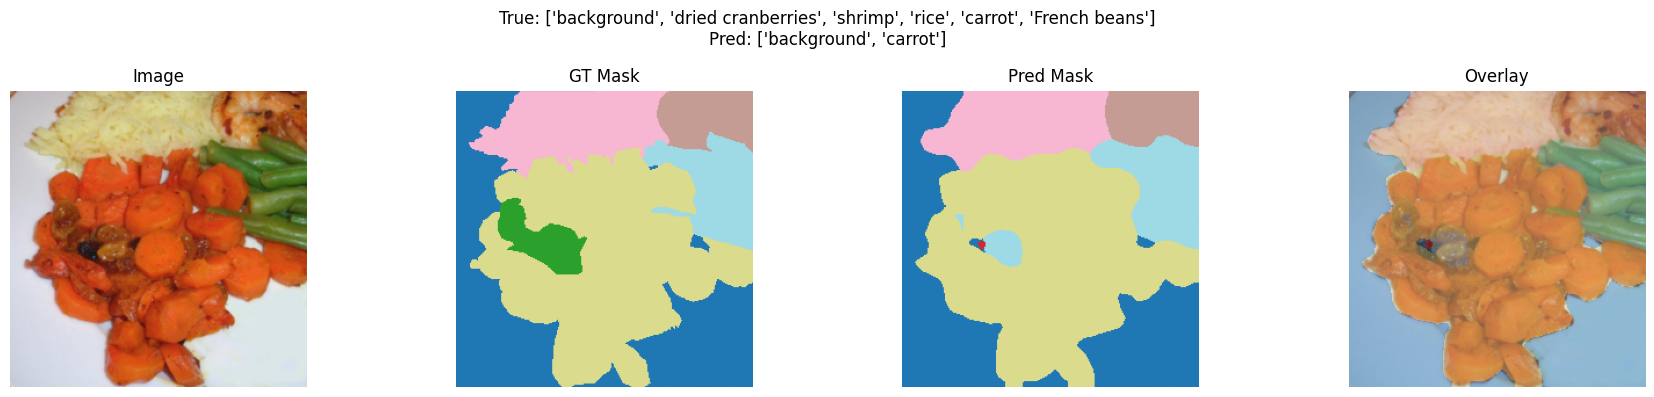

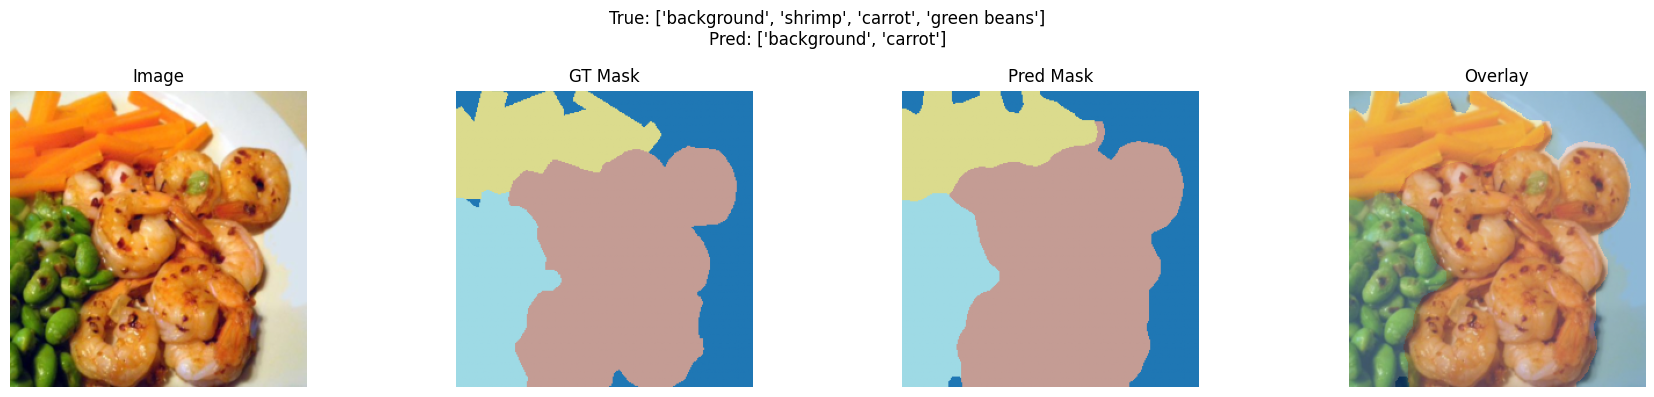

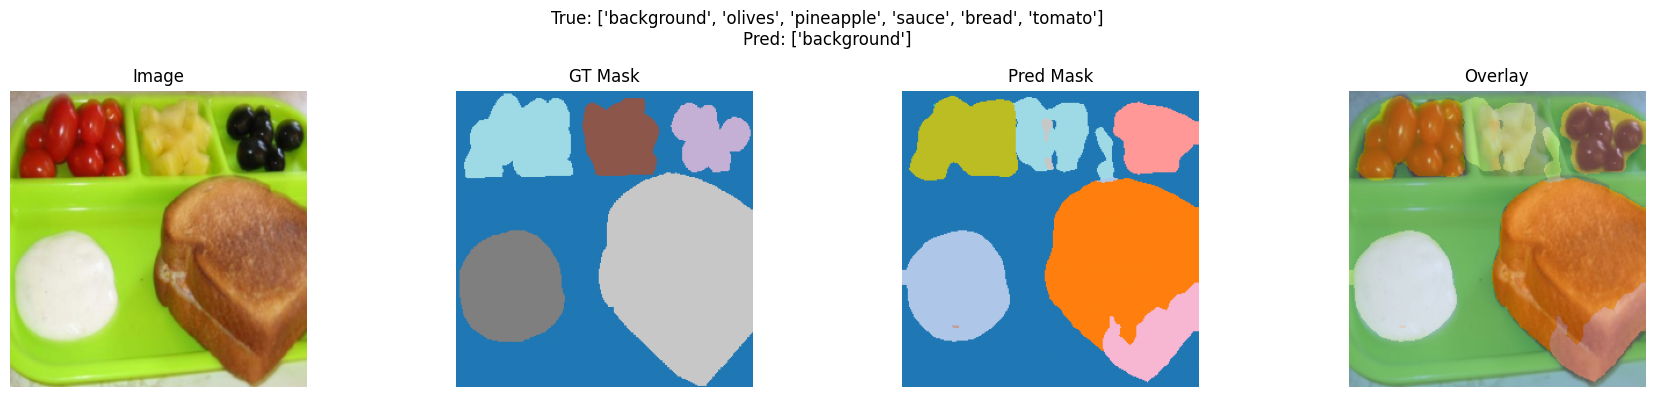

In [11]:
num_show = 3
for i in range(num_show):
    img = all_seg_targets[i]
    pred_mask = all_seg_preds[i]
    gt_mask = all_seg_targets[i]
    # Unnormalize image for display
    img_tensor = val_loader.dataset[i]["image"]
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    img_np = img_np.clip(0, 1)

    true_labels = [label_list[k] for k in np.where(all_cls_targets[i] == 1)[0]]
    pred_labels = [label_list[k] for k in np.where(all_cls_preds[i] == 1)[0]]

    fig, axs = plt.subplots(1, 4, figsize=(18, 4))
    axs[0].imshow(img_np)
    axs[0].set_title("Image")
    axs[1].imshow(gt_mask.squeeze(), cmap='tab20')
    axs[1].set_title("GT Mask")
    axs[2].imshow(pred_mask.squeeze(), cmap='tab20')
    axs[2].set_title("Pred Mask")
    axs[3].imshow(img_np)
    axs[3].imshow(pred_mask.squeeze(), cmap='tab20', alpha=0.4)
    axs[3].set_title("Overlay")
    for ax in axs:
        ax.axis('off')
    plt.suptitle(f"True: {true_labels}\nPred: {pred_labels}")
    plt.tight_layout()
    plt.show()